In [1]:
# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

from util import *
import torch
from heuristic.heuristic_solver import HeuristicSolver
from nce_model import NCEModel
from tqdm import tqdm

# 0. Load data

In [2]:
data = [parse_datafile(f'../data/reduced/cvrp_10000_100_10/instance_{i}') for i in tqdm(range(10000))]

TRAIN_PERCENTAGE, VALIDATION_PERCENTAGE, TEST_PERCENTAGE = 0.75, 0.05, 0.20
num_train, num_val, num_test = int(len(data) * TRAIN_PERCENTAGE), int(len(data) * VALIDATION_PERCENTAGE), int(len(data) * TEST_PERCENTAGE)
vrps_train, vrps_val, vrps_test = data[:num_train], data[num_train:num_train + num_val], data[num_train + num_val:]
print(f'Number of training instances: {len(vrps_train)}, validation instances: {len(vrps_val)}, test instances: {len(vrps_test)}')

100%|██████████| 10000/10000 [13:19<00:00, 12.50it/s] 


Number of training instances: 7500, validation instances: 500, test instances: 2000


# 1. 2-stage model

Epoch 0: Train Loss: 26386204.334894855 | Validation Loss: 25447087.009134434
Epoch 1: Train Loss: 25439674.10879262 | Validation Loss: 25412465.98658622
Epoch 2: Train Loss: 25434222.19956687 | Validation Loss: 25411563.008457683
Epoch 3: Train Loss: 25434296.546465013 | Validation Loss: 25411607.67947665
Epoch 4: Train Loss: 25434241.32396732 | Validation Loss: 25411685.56052362
Epoch 5: Train Loss: 25434222.52856538 | Validation Loss: 25420511.00589883
Early stopping at epoch 5
Test Loss: 25545937.19182576
Testing example instance VRP instance: ../data/reduced/cvrp_10000_100_10/instance_8000, predicted cost: 1833.3360595703125, actual cost: 394.5636896769532
Drawing actual solution


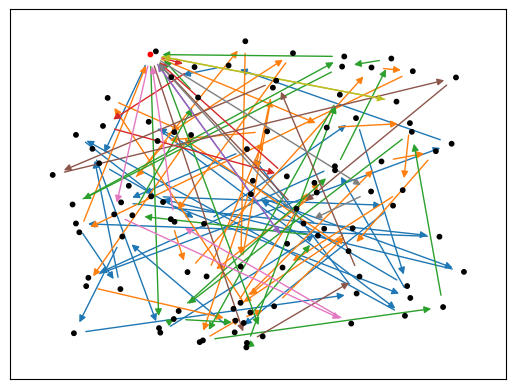

Drawing predicted solution


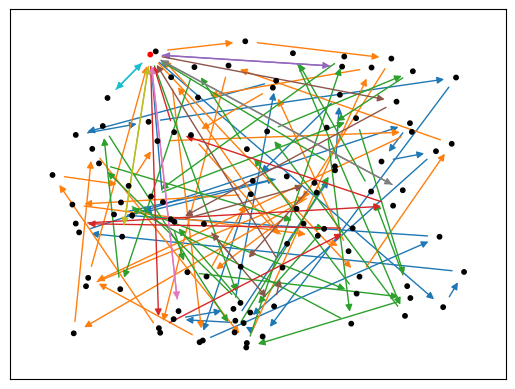

Actual edges (108): [0 -> 14, 0 -> 26, 0 -> 30, 0 -> 44, 0 -> 46, 0 -> 67, 0 -> 86, 0 -> 89, 0 -> 92, 1 -> 42, 2 -> 50, 3 -> 81, 4 -> 18, 5 -> 94, 6 -> 22, 7 -> 36, 8 -> 0, 9 -> 49, 10 -> 37, 11 -> 38, 12 -> 59, 13 -> 35, 14 -> 21, 15 -> 77, 16 -> 79, 17 -> 28, 18 -> 93, 19 -> 7, 20 -> 3, 21 -> 45, 22 -> 62, 23 -> 0, 24 -> 0, 25 -> 65, 26 -> 55, 27 -> 54, 28 -> 27, 29 -> 68, 30 -> 0, 31 -> 90, 32 -> 16, 33 -> 69, 34 -> 0, 35 -> 73, 36 -> 13, 37 -> 23, 38 -> 29, 39 -> 9, 40 -> 53, 41 -> 98, 42 -> 17, 43 -> 83, 44 -> 8, 45 -> 39, 46 -> 0, 47 -> 12, 48 -> 76, 49 -> 75, 50 -> 25, 51 -> 85, 52 -> 0, 53 -> 20, 54 -> 51, 55 -> 57, 56 -> 1, 57 -> 82, 58 -> 10, 59 -> 32, 60 -> 91, 61 -> 84, 62 -> 19, 63 -> 78, 64 -> 24, 65 -> 96, 66 -> 33, 67 -> 64, 68 -> 71, 69 -> 52, 70 -> 4, 71 -> 31, 72 -> 80, 73 -> 66, 74 -> 99, 75 -> 41, 76 -> 74, 77 -> 0, 78 -> 6, 79 -> 48, 80 -> 87, 81 -> 60, 82 -> 63, 83 -> 58, 84 -> 11, 85 -> 47, 86 -> 2, 87 -> 88, 88 -> 34, 89 -> 15, 90 -> 43, 91 -> 5, 92 -> 72, 93 -

  0%|          | 0/2000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


100%|██████████| 2000/2000 [07:02<00:00,  4.73it/s]


Accuracy: 0.10796434175120855, cost comparison: 12.304702689323205, regret: 186362.691772932


In [3]:
from two_stage_model import TwoStageModel
model = TwoStageModel(vrps_train, vrps_val, vrps_test, lr=1e-2)
model.train(num_epochs=10)
model.test()
test_and_draw(model, vrps_test[0])
test(model, vrps_test, GurobiSolver)

# 2a. SPO+ model (using true costs during training)

In [3]:
from spo_model import SPOModel
spo_model = SPOModel(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=1e-2)
spo_model.train(epochs=30, verbose=False, test_every=1)

0it [00:00, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


7500it [10:40, 11.71it/s]


Epoch 1 / 30 done, mean loss: 927857.1972333334, validation loss: 927056.0625


100%|██████████| 2000/2000 [06:10<00:00,  5.40it/s]


Accuracy: 0.11361047863524439, cost comparison: 12.122017730049079, regret: 183351.0547849987


7500it [10:49, 11.54it/s]


Epoch 2 / 30 done, mean loss: 908490.3500083333, validation loss: 921093.3125


 44%|████▎     | 874/2000 [03:05<04:07,  4.55it/s]

In [5]:
spo_model.cost_model.eval()
vrp = vrps_test[2]
costs = spo_model.cost_model(torch.tensor([edge.features for edge in vrp.edges]))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)

In [6]:
# export the model
torch.save(spo_model.cost_model.state_dict(), '../models/spo_model.pt')

# 2b. SPO+ model (without using true costs during training)

In [7]:
from spo_model import SPOModelNoTrueCosts

spo_model_no_true_costs = SPOModelNoTrueCosts(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=1e-2)
spo_model_no_true_costs.train(epochs=20, verbose=False, test_every=1)

In [8]:
spo_model_no_true_costs.cost_model.eval()
vrp = vrps_test[0]
costs = spo_model_no_true_costs.cost_model(torch.tensor([edge.features for edge in vrp.edges]))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)

# 3a. NCE model (without using true costs during training)

In [9]:
nce_model = NCEModel(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=1e-3)
nce_model.train(epochs=50, verbose=False, test_every=2)

In [ ]:
nce_model.cost_model.eval()
vrp = vrps_test[0]
costs = nce_model.cost_model(torch.tensor([edge.features for edge in vrp.edges]))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)

# 3b. NCE model (using true costs during training)

In [ ]:
from nce_model import NCETrueCostLoss

nce_model_true_costs = NCEModel(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=8e-3)
nce_model_true_costs.criterion = NCETrueCostLoss({vrp: [vrp.actual_solution] for vrp in vrps_train})
nce_model_true_costs.train(epochs=40, verbose=False, test_every=1)

In [ ]:
nce_model_true_costs.cost_model.eval()
vrp = vrps_train[0]
costs = nce_model_true_costs.cost_model(torch.tensor([edge.features for edge in vrp.edges]))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)